# Libraries

In [1]:
# libraries
import networkx as nx
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import re
import itertools
import math
np.random.seed(5)

# Basic networkx testing

In [2]:
G = nx.Graph()
elist = [('a', 'b', 0.3), ('b', 'c', 0.9), ('a', 'c', 0.5), ('c', 'd', 1.2)]
G.add_weighted_edges_from(elist)
print(G.edges)

[('a', 'b'), ('a', 'c'), ('b', 'c'), ('c', 'd')]


In [3]:
dict(G['a'])

{'b': {'weight': 0.3}, 'c': {'weight': 0.5}}

In [4]:
nx.get_edge_attributes(G,'weight')

{('a', 'b'): 0.3, ('a', 'c'): 0.5, ('b', 'c'): 0.9, ('c', 'd'): 1.2}

In [5]:
re.sub(r'[^a-zA-Z]', '', 'bs1')

'bs'

# Helper functions to build and draw graphs

In [6]:
# build graph with nodes, edges, and coordinates
def build_graph(node_list, edge_list, coords):
    G = nx.DiGraph()
    G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    pos = dict([(n,coords[i]) for i,n in enumerate(node_list)])
    nx.set_node_attributes(G, pos, 'pos') #, pos_graph, 'pos_graph')
    return(G)

In [7]:
# input: list of graphs, edge tuple, dict of edge attributes of form (attr_name: attr_value)
def add_and_set_edge_attributes(G_list, edge, attr_dict):
    for g in G_list:
        g.add_edge(*edge)
        nx.set_edge_attributes(g, {edge: attr_dict})

In [87]:
# random edge costs used for testing; see if the paths still adhere to mode change constraints 
# input: graph, number of time intervals to consider
# output: vector of costs, where cost[i] is the cost associated with time interval i
# *ensure that the costs adhere to FIFO; 
# *that is, ((cost of interval i+1) -  (cost of interval i)) >= -length_interval
def random_edge_costs(G, num_intervals, interval_length, costLB, costUB):
    for e in G.edges.keys():
        cost_vector = []
        for i in range(num_intervals):          
            #print(i)
            if i == 0:    
                ecost = np.random.uniform(costLB, costUB)
                #print(ecost)
                cost_vector.append(ecost)
                nx.set_edge_attributes(G, {e: {'cost'+str(i): ecost}})
               #print(cost_vector)
            else:
                while True:
                    ecost = np.random.uniform(costLB, costUB)  # generate a cost
                    #print(ecost)
                    if (ecost - cost_vector[i-1]) >= -interval_length:  # check the FIFO constraint
                        cost_vector.append(ecost)
                        nx.set_edge_attributes(G, {e: {'cost'+str(i): ecost}})
                        #print(cost_vector)
                        break  # if FIFO constraint is met, go to next interval. o/w, return to top of while loop and regenerate a cost 
    return G

In [88]:
# find total cost of shortest weighted path
# input: graph, edges of shortest path, attribute used as weight
# output: total cost of shortest path
def sp_total_cost(G, sp_edges, weight):
    total_cost = 0
    for e in sp_edges:
        total_cost += G.edges[e][weight]
    #print('Total cost of the shortest path from org to dst = ', round(total_cost,2))  
    return(total_cost)

In [89]:
# function that returns a mapping from the long names of the modes included in the graph to the mode's color
# this will be used to create a legend for the node colors to their associated travel mode 
def node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap):
    modes_incl_long = [all_mode_namemap[m] for m in modes_included]
    longmode_cmap_subset = {all_mode_namemap[m]:c for m,c in all_shortmode_cmap.items() if all_mode_namemap[m] in modes_incl_long}
    return longmode_cmap_subset

In [90]:
# draw the graph, which includes nodes located by their coordinates, and edges
# if show_zones == Y, then also draw the walking catchment zone around each fixed node
def draw_graph(G, all_node_color_map, node_color_legend, node_size, font_size, font_color, 
               edge_color, edge_width):
    fig, ax = plt.subplots(figsize=(12,10))
    node_coords = nx.get_node_attributes(G, 'pos')
    
    node_color = [all_node_color_map[re.sub(r'[^a-zA-Z]', '', node)] for node in G]
    
    nx.draw(G, pos=node_coords, with_labels = True, node_color = node_color, font_color = font_color, 
            font_size = font_size, font_weight = 'bold', node_size = node_size, arrowsize = 16, edge_color = edge_color, 
            width = edge_width, alpha = 0.8, ax=ax)
    ax.set_axis_on() # turns on axis
    ax.margins(0.1,0.1)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    # add legend for node color
    inv_node_cmap = {val:key for key,val in node_color_legend.items()}  # dict of form {color: long_mode_name}
    for v in set(inv_node_cmap.keys()):
        if inv_node_cmap[v] in ['org','dst']:
            ax.scatter([],[], c=v, label='org/dst')
        else:
            ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'lower right')
        
#     ax.set_xlim([axlims[0],axlims[1]])
#     ax.set_ylim([axlims[2],axlims[3]])
    return ax

In [91]:
# add legend for edge color
def add_edge_color_legend(edge_color_type_map, ax, loc):
    for v in edge_color_type_map.keys():
        ax.plot([],[], c=v, label=edge_color_type_map[v])
        ax.legend(loc = loc)

In [92]:
#nx.get_node_attributes(G_u_od, 'pos')['org']

In [93]:
# show walking catchment zones around each fixed dropoff node
# input: graph, set of axes, list of fixed nodes, and max walking distance W
# output: circles drawn around locations (coordinates) of fixed nodes
def draw_WCZ(G, ax, fixed_node_list, W):
    #fig, ax = plt.subplots(figsize=(8,6))
    ax.set_aspect(1)
    node_coords = nx.get_node_attributes(G, 'pos')
    for n in fixed_node_list:
        center = node_coords[n]
        draw_circle = plt.Circle(center, W, fill = False, linestyle = '--')
        ax.add_artist(draw_circle)

In [94]:
# draw the edge labels (cost, in this case)
def draw_edge_labels(G, ax, labels):
    node_coords = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx_edge_labels(G, pos=node_coords, edge_labels=labels, ax=ax)

In [95]:
# make maps from short_mode_name: long_mode_name and short_mode_name: color
all_mode_namemap = {'bs':'bikeshare', 'pt':'PT', 't':'TNC', 'pv':'personal vehicle', 
                    'k':'park&ride', 'pb':'personal bike', 'sc': 'scooter', 'vsc':'virtual scooter', 
                    'ps':'physical stop', 'r': 'route node',
                    'org': 'org', 'dst': 'dst'}
all_shortmode_cmap = {'bs':'green', 'pt':'blue', 't':'red', 'pv':'purple', 'k':'black', 
                      'pb':'magenta', 'sc': 'darkcyan', 'vsc':'darkcyan',
                      'ps':'blue', 'r': 'grey',
                      'org':'darkorange', 'dst': 'darkorange'}

# Build unimodal graphs: PT, TNC, personal vehicle, personal bike, bikeshare, scooter

In [96]:
# define which nodes are fixed and which come from flexible networks 
all_fix_pre = ['bs','ps','k']  # prefix for fixed nodes
all_flex_pre = ['t', 'pb', 'pv', 'sc']  # prefix for flexible dropoff nodes

### Public Transit
To build a PT graph, we need: physical stop node (with coordinates) and route nodes (virtual). Physical nodes are connected to route nodes by boarding/alighting edges. Route nodes are connected by traversal edges.

In [97]:
# PT graph
ps_nodes = ['ps'+str(i) for i in range(1,6)] 
coords_ps = [(0, 4), (20, 4), (0, 12), (20, 12), (4, 15)]
G_pt = build_graph(ps_nodes, [], coords_ps)

In [100]:
# now add at least one virtual route node associated with each pt physical stop 
route_nodes = []
ba_edges = [] # board and alight edge
for i, phys_stop in enumerate(ps_nodes):
    temp = re.findall(r'\d+', phys_stop)    
    rt_node = 'r' + temp[0]
    coord_rt = (coords_ps[i][0] + 1.5, coords_ps[i][1] + 1.5)
    att_dict = {'pos': coord_rt}
    route_nodes.append((rt_node, att_dict))
    ba_edges.append((phys_stop, rt_node))
    ba_edges.append((rt_node, phys_stop))
# add another route node going through physical stop 3
route_nodes.append(('r'+str(len(ps_nodes)+1), {'pos': (-1.5,5.5)}))
ba_edges.append(('r'+str(len(ps_nodes)+1), 'ps1'))
ba_edges.append(('ps1', 'r'+str(len(ps_nodes)+1)))
G_pt.add_nodes_from(route_nodes)
# add boarding and alighting edges
G_pt.add_edges_from(ba_edges)

In [101]:
# define route edges
rt_edge_in = [('r1','r2'), ('r3','r4'), ('r6','r5')]
rt_edge_out = [(e[1],e[0]) for e in rt_edge_in]
rt_edges = rt_edge_in + rt_edge_out
G_pt.add_edges_from(rt_edges)

In [102]:
G_pt.nodes

NodeView(('ps1', 'ps2', 'ps3', 'ps4', 'ps5', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6'))

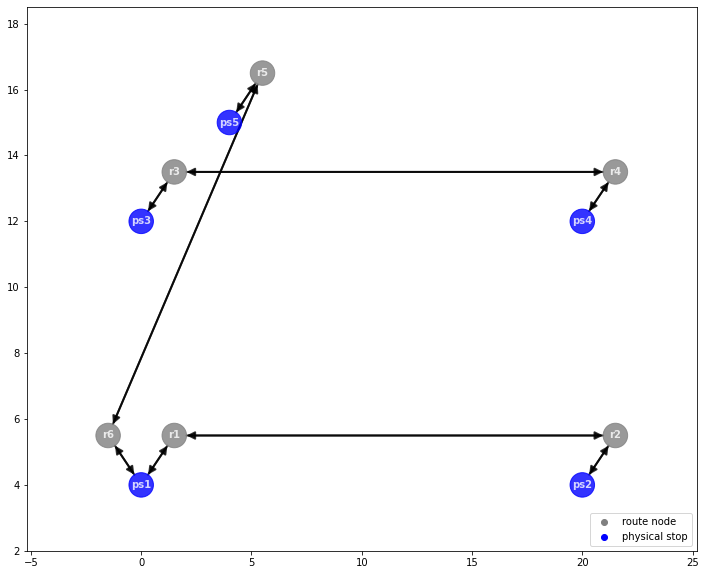

In [103]:
modes_included = ['ps','r']
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_pt, all_shortmode_cmap, legend_subset, 600, 10, 'white', 'black', 2)
plt.show()

### TNC

In [104]:
# TNC graph
n_tnc = 6
ntnc_list = ['t'+str(i) for i in range(1, n_tnc+1)]
etnc_in = [('t1','t2'),('t2','t3'),('t3','t4'),('t4','t5'),('t5','t6'),('t6','t1'),('t6','t3')]
etnc_out = [(e[1],e[0]) for e in etnc_in]
etnc_list = etnc_in + etnc_out
coords_tnc = [(0,2),(0,15),(10,15),(20,15),(20,2),(10,2)]
G_tnc = build_graph(ntnc_list, etnc_list, coords_tnc)

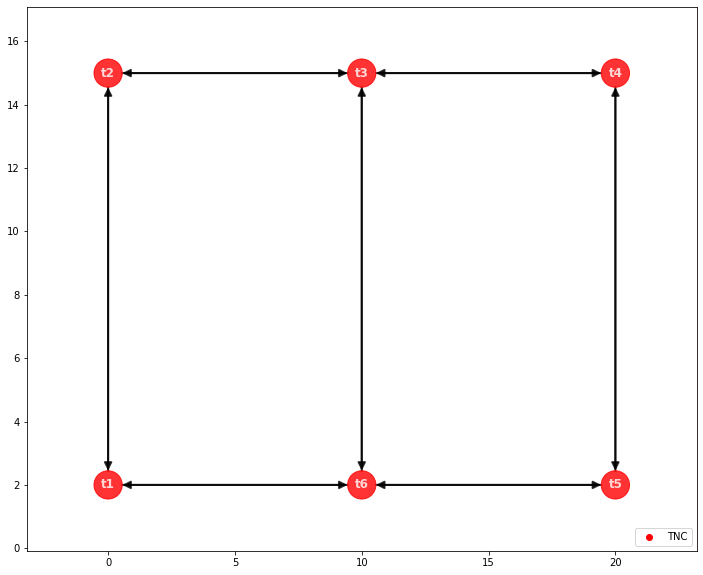

In [105]:
modes_included = ['t']
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_tnc, all_shortmode_cmap, legend_subset, 800, 12, 'white', 'black', 2)
plt.show()

### Personal Vehicle

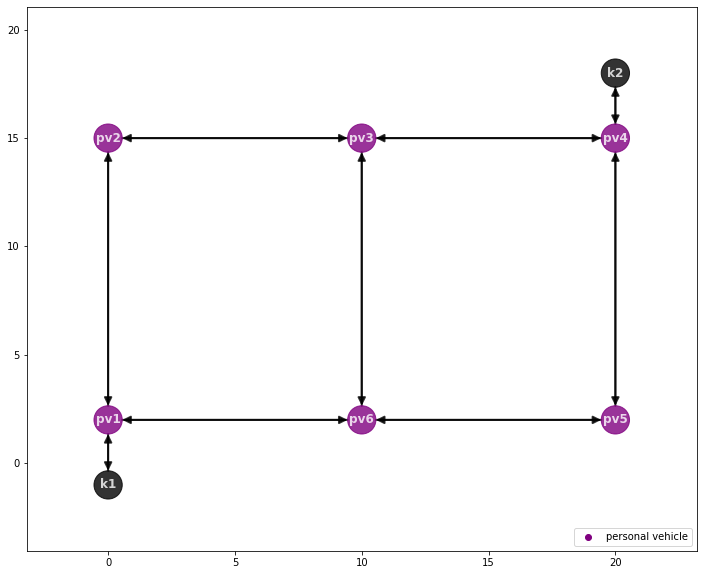

In [106]:
# copy the pv road network from the tnc network
G_pv = G_tnc.copy()
mapping = {'t'+str(i): 'pv'+str(i) for i in range(len(G_tnc.nodes)+1) if 't'+str(i) in G_pv}
G_pv = nx.relabel_nodes(G_pv, mapping, copy=False)
# add parking nodes
num_park = 2  # number of parking nodes
nodes_park = ['k'+str(i) for i in range(1,num_park+1)]  # park and ride node names
coords_park = [(0,-1), (20,18)]
park_edge_in = [('pv1','k1'),('pv4','k2')]  # could invoke the nn function to find which pv node to connect to
park_edge_out = [(e[1],e[0]) for e in park_edge_in]  # parking edges
G_pv.add_nodes_from([(k, {'pos':coords_park[i]}) for i,k in enumerate(nodes_park)])
G_pv.add_edges_from(park_edge_in + park_edge_out)
modes_included = ['pv']
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_pv, all_shortmode_cmap, legend_subset, 800, 12, 'white', 'black', 2)

### Personal Bike

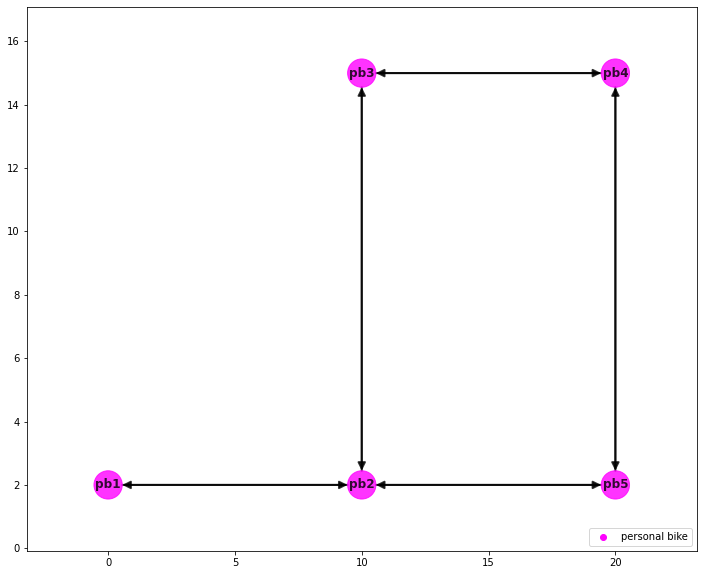

In [107]:
# copy the personal bike network from full road network, only retaining a subset
G_pb = G_tnc.copy()
G_pb.remove_nodes_from(['t2'])
non_bike_edges_in = [('t1','t2'), ('t2','t3')]
non_bike_edges_out = [(e[1],e[0]) for e in non_bike_edges_in]
non_bike_edges = non_bike_edges_in + non_bike_edges_out
G_pb.remove_edges_from([non_bike_edges])
mapping = {'t'+str(i): 'pb'+str(i) for i in range(len(G_tnc.nodes)+1) if 't'+str(i) in G_pb}
G_pb = nx.relabel_nodes(G_pb, mapping, copy=False)
mapping = {'pb6':'pb2'}
G_pb = nx.relabel_nodes(G_pb, mapping, copy=False)
modes_included = ['pb']
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_pb, all_shortmode_cmap, legend_subset, 800, 12, 'black', 'black', 2)
#plt.show()

### Bikeshare

NodeView(('bs1', 'bs2', 'bs3', 'bs5', 'bs4'))

Text(0.5, 1.0, 'Complete Bikeshare Network')

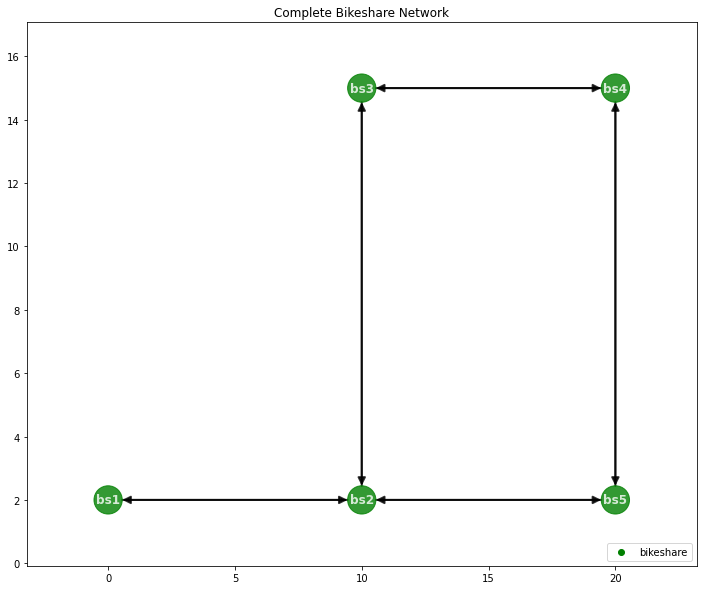

In [108]:
G_bs_full = G_pb.copy()
mapping = {'pb'+str(i): 'bs'+str(i) for i in range(len(G_pb.nodes)+1) if 'pb'+str(i) in G_bs_full}
G_bs_full = nx.relabel_nodes(G_bs_full, mapping, copy=False)
G_bs_full.nodes
modes_included = ['bs']
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_bs_full, all_shortmode_cmap, legend_subset, 800, 12, 'white', 'black', 2)
ax.set_title('Complete Bikeshare Network')

In [109]:
# Now choose 3 nodes as depot nodes
depots = ['bs1', 'bs2', 'bs4']
# Consolidate the graph by removing any nodes that are not depot nodes
nodes_remove = list(set(G_bs_full.nodes) - set(depots))
G_bs = nx.create_empty_copy(G_bs_full, with_data=True)  # replicates graph but removes edges
G_bs.remove_nodes_from(nodes_remove)
mapping = {'bs1': 'bs1', 'bs2': 'bs2', 'bs4':'bs3'}  
inv_mapping = dict([(val,key) for key,val in mapping.items()])
G_bs = nx.relabel_nodes(G_bs, mapping, copy=False)
bs_depot_pairs = list(itertools.permutations(list(G_bs.nodes), 2))
# Add shortcut b/w all depot edges. Don't calculate shortcut edge weight yet; will be done in subsequent step
for e in bs_depot_pairs:
    G_bs.add_edge(*e)

Text(0.5, 1.0, 'Bikeshare Network: depots & shortcut edges')

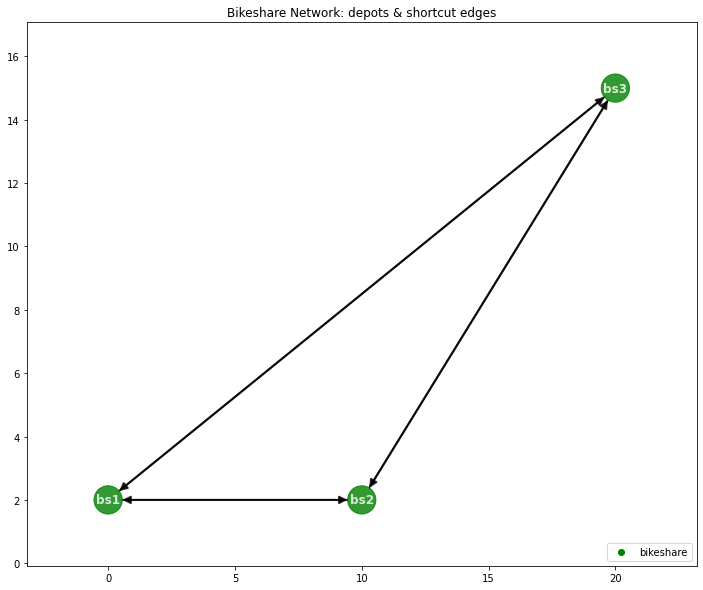

In [110]:
ax = draw_graph(G_bs, all_shortmode_cmap, legend_subset, 800, 12, 'white', 'black', 2)
ax.set_title('Bikeshare Network: depots & shortcut edges')

### Scooter

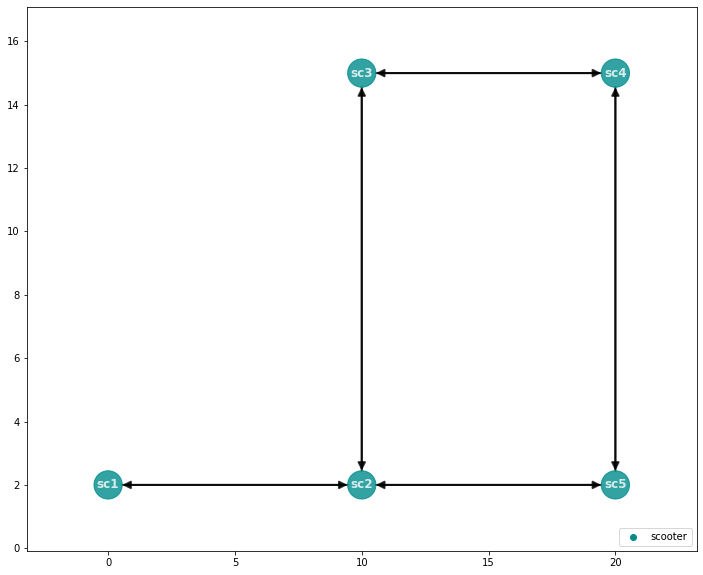

In [111]:
G_sc = G_pb.copy()
mapping = {'pb'+str(i): 'sc'+str(i) for i in range(len(G_pb.nodes)+1) if 'pb'+str(i) in G_sc}
G_sc = nx.relabel_nodes(G_sc, mapping, copy=False)
modes_included = ['sc']
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_sc, all_shortmode_cmap, legend_subset, 800, 12, 'white', 'black', 2)
plt.show()

# Build the supernetwork

In [112]:
# this dict defines which graphs correspond to each mode type 
all_graphs_dict = {'bs':G_bs, 'pt':G_pt, 't':G_tnc, 'pv':G_pv, 'pb':G_pb, 'sc':G_sc}

In [113]:
# this dict defines the node names corresponding to each mode type 
all_modes_nodes = {'bs':['bs'], 'pt':['ps','r'], 't':['t'], 'sc':['sc'], 'pv':['pv','k'], 'pb':['pb']}  

### Choose which networks to include in the supernetwork 

In [114]:
# this list is the parameter that defines which modes to include in the supernetwork
modes_included = ['bs','pt','t','sc','pv']

In [115]:
# this dict defines which modes and nodes are included in the supernetwork
modes_nodes_included = {k:v for k,v in all_modes_nodes.items() if k in modes_included}

networks_included = [all_graphs_dict[m] for m in modes_included]  # set([all_graphs_dict[m] for m in modes_included])

# prefixes for fixed nodes in the supernetwork
fix_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_fix_pre]
# prefixes for flex nodes in the supernetwork
flex_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_flex_pre]
print('fixed nodes included = ', fix_pre)
print('flex nodes included = ', flex_pre)

fixed nodes included =  ['bs', 'ps', 'k']
flex nodes included =  ['t', 'sc', 'pv']


### Combine the unimodal networks and draw

In [279]:
# combine all the graphs together into one supernetwork
G_u = nx.union_all(networks_included)

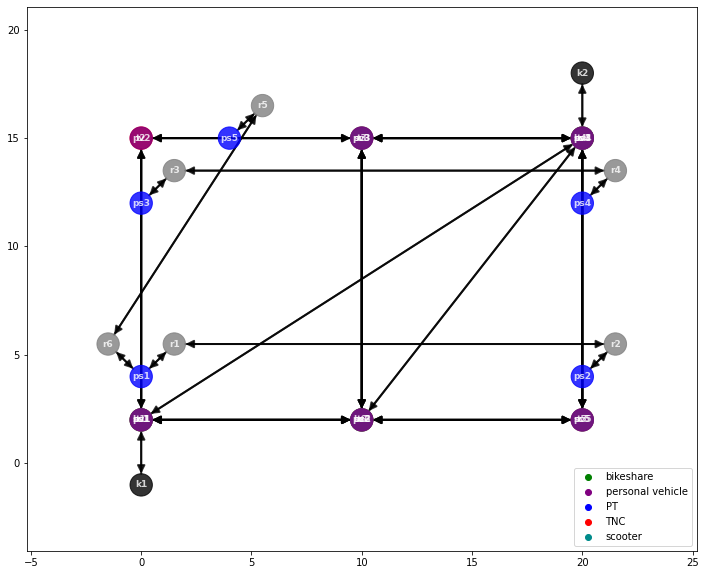

{'pos': (0, 4)}

{'pos': (1.5, 5.5)}

In [280]:
legend_subset = node_color_legend(modes_included, all_mode_namemap, all_shortmode_cmap)
ax = draw_graph(G_u, all_shortmode_cmap, legend_subset, 500, 9, 'white', 'black', 2)
plt.show()
G_u.nodes['ps1']
G_u.nodes['r1']

In [281]:
G_u.nodes

NodeView(('bs1', 'bs2', 'bs3', 'ps1', 'ps2', 'ps3', 'ps4', 'ps5', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 't1', 't2', 't3', 't4', 't5', 't6', 'sc1', 'sc2', 'sc3', 'sc5', 'sc4', 'pv1', 'pv2', 'pv3', 'pv4', 'pv5', 'pv6', 'k1', 'k2'))

In [282]:
# input: graph and jitter parameter (how much to adjust the x and y coordinates)
# output: adjusted graph with jittered coordinates
# this function is only for visualization purposes. the original coordinates should remain unchanged
def jitter_nodes(G, jitter_param):
    #G_adj = G.copy()
    j = jitter_param
    # adjust the nodes positions in the copy 
    for node in G.nodes.keys():
        #print(G_tnc.nodes[node]['pos'])
        adj_x = G.nodes[node]['pos'][0] + jitter_param
        adj_y = G.nodes[node]['pos'][1] + jitter_param
        nx.set_node_attributes(G, {node: {'pos':(adj_x, adj_y)}})
    return G

In [283]:
modes_included

['bs', 'pt', 't', 'sc', 'pv']

In [284]:
# problem is that tnc, pb, and pv intersections overlap. 
# define and adjusted graph for drawing purposes; not the real graph in physical world

# the TNC graph is the reference graph for drawing since it is the basic road network; # it will remain in its original position 
adjusted_mode_dict = {'t': G_tnc}

# adjust the graphs in the supernetwork using the jitter function
# this is strictly for plotting
for j, m in enumerate(modes_included):
    if m != 't':  # tnc graph is the "base" road network so it will not be adjusted
        G_adj = all_graphs_dict[m].copy()
        jitter_nodes(G_adj, jitter_param=(j+1)*2)
        adjusted_mode_dict[m] = G_adj

{'pos': (0, 2)}

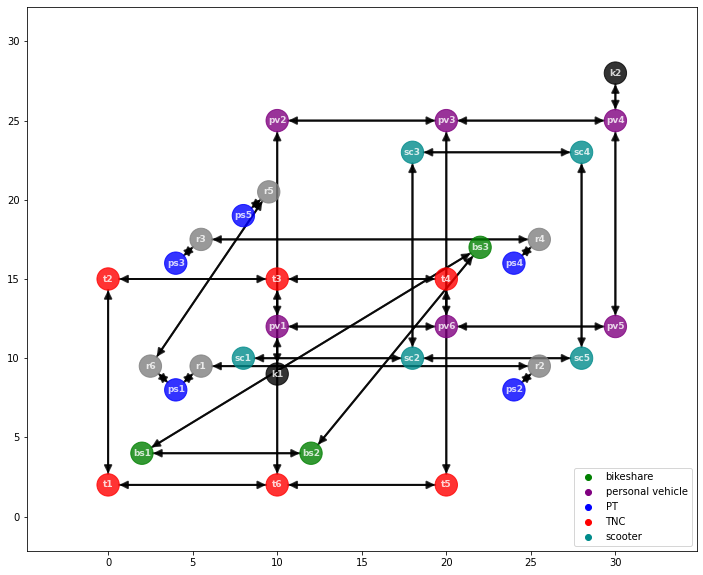

In [285]:
G_u_adj = nx.union_all(G for G in adjusted_mode_dict.values()) 
ax = draw_graph(G_u_adj, all_shortmode_cmap, legend_subset, 500, 9, 'white', 'black', 2)
G_u.nodes['bs1']  # confirm that the original coordinates did not change

In [286]:
# returns the travel mode the corresponds to the node
def mode(node_name):
    mode_of_node = re.sub(r'[^a-zA-Z]', '', node_name)
    return mode_of_node
mode('bs1')

'bs'

## Find Euclidean distance between all nodes in the graph

In [287]:
# make node_ID map of form {id_number: node_name}. also make inverse node ID map of form {node_name: id_number}
# ex  {0:bs1  1:bs2  ...}
nid_map = dict([(i, node_id) for i, node_id in enumerate(list(G_u.nodes))])
inv_nid_map = {v: k for k, v in nid_map.items()}

In [288]:
# separate nid map into fixed and flex
# separate nodes depending on whether fixed or flex network 
nid_map_fixed = {key:val for key,val in nid_map.items() if mode(val) in fix_pre}  # nid_map for fixed network nodes
nid_map_flex = {key:val for key,val in nid_map.items() if mode(val) in flex_pre}  # nid_map for flex network nodes

In [289]:
# coordinate matrix for all nodes in supernetwork:
# 2 columns, where col 0 is x-coord, col 1 is y-coord
# the row number corresponds to the node ID number. can use the nid map to look up the node name that 
# corresponds to the node ID number
def get_coord_matrix(G, node_id_map):
    coord_matrix = np.empty([len(node_id_map), 2])  # initialize
    for i in range(coord_matrix.shape[0]):    # then fill
        id_name = node_id_map[i]    # map from i to node_id name
        coord_matrix[i,0] = nx.get_node_attributes(G, "pos")[id_name][0]   # fill with x-coordinate
        coord_matrix[i,1] = nx.get_node_attributes(G, "pos")[id_name][1]   # fill with y-coordinate
    return coord_matrix

In [290]:
# find the euclidean distance between a selected row and all rows in a reference matrix
# this will be used to see which nodes are in walking catchment zone of a node of interest
def calc_dist(row, matrix_ref):
    #sq_diff = np.nan_to_num(row - matrix_ref, nan=0)**2
    sq_diff = (row - matrix_ref)**2   # row is broadcast to size of matrix_ref
    ssq_diff = np.sqrt(np.sum(sq_diff,axis=1))
    return ssq_diff

In [291]:
coord_matrix = get_coord_matrix(G_u, nid_map)
# euclidean distance matrix: euc_dist[i,j] is the euclidean distance from node i to node j
euc_dist = np.empty([len(nid_map), len(nid_map)])
for i in range(euc_dist.shape[0]):
    dist_to_all_nodes = calc_dist(coord_matrix[i], coord_matrix)  # calc distance from node i to all other nodes
    euc_dist[i] = dist_to_all_nodes

## Find traversal edge costs in full graph

### Choose one of the following ways to define edge costs: 1) dependent on mode type, or 2) completely random 

### 1) Edge costs depend on the mode type of the edge

In [292]:
speed_params = {'bs':3, 'pt':4, 't':6, 'pv':6, 'k':6, 'pb':3, 'sc':3, 'w':1}  # avg speed

In [293]:
# # some made-up parameters for each travel mode
# speed_params = {'bs':3, 'pt':4, 't':6, 'pv':6, 'k':6, 'pb':3, 'w':1}  # avg speed
# reliability_params = {'bs':0, 'pt':7, 't':3, 'pv':6, 'k':6, 'pb':0, 'w':0}  # additive time relative to average travel time
# price_params = {'bs':1, 'pt':1, 't':3, 'pv':3, 'k':6, 'pb':0, 'w':0}   # cost/dist

# # find travel time weights of each traversal edges
# # for simplicity, without data: travel time = distance / velocity
# for e in G_u.edges.keys():
#     # both e[0] and e[1] are the same because only dealing with traversal edges, haven't yet added transfers. unless we are dealing with a k-pv traversal node in pv network
#     travel_mode = mode(e[0]) 
#     e_length = euc_dist[inv_nid_map[e[0]], inv_nid_map[e[1]]]  # length of edge
#     avg_tt = e_length / speed_params[travel_mode]   # travel time of edge
#     rel_tt = avg_tt + reliability_params[travel_mode]  # reliability of edge 
#     price = e_length * price_params[travel_mode]  # price of edge = length*(cost/length)
#     b1, b2, b3 = 1.5, 1, 1  # beta params
    
#     base_cost = round(b1*avg_tt + b2*rel_tt + b3*price,1)  # cost function
#     nx.set_edge_attributes(G_u, {e: {'avg_tt': avg_tt, 'rel_tt': rel_tt, 'price': price, 'cost': base_cost}})
    
#     # to test out time-dependent SP, we will make up 4 additional costs: 
#     # (random number b/w 0.7 and 1.3)*base_cost. these will be added as edge attributes
#     for i in range(5):
#         new_cost = np.random.uniform(0.7, 1.3)*base_cost
#         nx.set_edge_attributes(G_u, {e: {'cost'+str(i): new_cost}})

# # test: what are the 5 costs for the ('bs1','bs2') edge
# for i in range(5):
#     print(G_u.edges[('bs1','bs2')]['cost'+str(i)])

### 2) Edge costs are completely random, which is useful for testing

In [294]:
num_intervals = 10
length_interval = 30

In [295]:
G_test = G_u.copy()  # helpful to do things on a graph copy 
# find random edge costs for all edges except for the precomputed bike share edges. we found these edge costs earlier
# remove bikeshare edges, find remaining edge costs, then add them back? probably a more efficient way to do this 
bs_edges = [(e[0], e[1]) for e in G_u.edges if (e[0].startswith('bs') or e[1].startswith('bs'))]
G_test.remove_edges_from(bs_edges)  # remove bs edges
random_edge_costs(G_test, num_intervals, length_interval, 20, 60)  # find random edge costs for remaining edges. 6 intervals, each 30 sec long
G_u = G_test.copy()

In [296]:
# Precompute the shortest path between each pair of depot nodes 
random_edge_costs(G_bs_full, num_intervals, length_interval, 20, 60)
for e in bs_depot_pairs:
    # find shortest path b/w depot nodes using "cost1" as the weight
    sp = nx.dijkstra_path(G_bs_full, inv_mapping[e[0]], inv_mapping[e[1]], 'cost1')  
    sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)]
    total_cost = sp_total_cost(G_bs_full, sp_edges, 'cost1') 
    # make the cost dict, which is constant by time of day
    bs_cost_dict = dict([('cost'+str(i), total_cost) for i in range(length_interval)])    
    add_and_set_edge_attributes([G_u], (e[0],e[1]), bs_cost_dict)
#nx.get_edge_attributes(G_u, 'cost1')

In [297]:
# define edges of initial graph as traversal
# traversal edges
nx.set_edge_attributes(G_u, 'traversal', 'type')  # real graph
nx.set_edge_attributes(G_u_adj, 'traversal', 'type')  # adj graph

# Scooter location observation data
### This data is used to determine cost of reaching nearest scooter

Consider a given time interval. We have historical observations of the last 10 days for this time interval. These observations consist of coordinates. We do not need scooter IDs. As a data structure, we can model the data as a dict of the form {date: list of coordinates for past 10 days}. <br>
Assume a person can transfer to a scooter from every fixed node in the graph (PT, parking, & bikeshare depot). Then, a transfer edge exists from each fixed node to the nearest physical scooter node. The task of determining the cost parameters of the transfer edge can be completed as follows: <br>
1. for each fixed node n <br>
    1. for each historical date d:  <br>
        1. find euclidean distance from n to all scooter observations  <br>
        1. choose minimum distance i.e. nearest neighbor  <br>
        1. store in list. at the end of this inner loop, we should have 10 items in the list <br>
    1. find average of min distance list, convert to walk time <br>
    1. find 95th percentile of min distance list, convert to time <br>
    1. in the transfer edge code, assign these cost parameters to the cost of the edge (n, nearest_neighbor_n)<br>

This model has some error because the fixed nodes are connected to the nearest scooter nodes (albeit with calibrated cost parameters for the transfer edges). This leads to potential overestimation of path costs on avg <br>
Ex. A person alights a bus. They walk 500 m to the nearest scooter. In reality, they would hop on scooter network at the node that is nearest to the scooter they just picked up. In this model, they are assumed to hop on the scooter network at the node that is nearest to the bus stop. This simplifying assumption makes it possible to build the supernetwork. 

In [298]:
# inputs:
# output: dict of dicts
def gen_data(G, n_days, n_intervals, n_obs_lb, n_obs_ub, xlb, xub, ylb, yub, node_id_map_fixed, b1, b2, walk_speed):
    # generate some fake data

    # initialize the scooter cost dictionary: key is the fixed node, the value is dict of costs (different cost for the different time intervals)
    all_costs = dict([(n, {}) for n in node_id_map_fixed.values()])
    
    # For subsequent visualization purposes
    fig, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(16,8))
    plt.suptitle('Example: Scooter observations (red) for time interval 0 shown relative to fixed node bs1 (blue)')
    # for subsequent plotting purposes 
    node_coords = np.array([val for key,val in nx.get_node_attributes(G_u, 'pos').items() if key in list(node_id_map_fixed.values())])

    for i in range(n_intervals):  # each time interval 
        obs = {}  # obs is a dict, where the key is the day, the value is an array of coordinates representing different observations
        for j in range(n_days):  # each day
            n_obs = np.random.uniform(n_obs_lb,n_obs_ub)  # how many scooter observations for the day-time interval pair
            # generate some random data: data is a coordinate matrix
            data = [(round(np.random.uniform(-20,20),2), round(np.random.uniform(-20,20),2)) for k in range(int(n_obs))]  
            obs[j] = np.array(data)  

        # find edge cost
        #test = {} # a dict where the key is the fixed node, the value is a dict of cost attributes pertaining to the cost of obtaining the nearest scooter
        node_cost_dict = {}
        for n in node_id_map_fixed.values():
            all_min_dist = np.empty((1,n_days))            
            
            
            for d in range(n_days):
                all_dist = calc_dist(np.array(G.nodes[n]['pos']), obs[d])  # dist from the fixed node to all observed scooter locations 
                min_dist = np.min(all_dist)  # choose the scooter with min dist. assume a person always walks to nearest scooter
                all_min_dist[0,d] = min_dist # for the given day, the dist from the fixed node to the nearest scooter is min_dist
                
                # **********************************
                # JUST FOR VISUALIZATION PURPOSES
                # for fixed node bs1 and time interval, visualize the scooter location data for each day
                if (i == 0 and n == 'bs1'):
                    row = d // 5
                    col = d if d <=4 else (d-5)
                    for k in range(len(obs[d][:,0])):
                        axs[row,col].plot([node_coords[0,0], obs[d][k,0]], [node_coords[0,1], obs[d][k,1]], 
                                 c='grey', ls='--', marker = 'o', mfc='r', zorder=1)
                    axs[row,col].scatter(x = node_coords[0,0], y = node_coords[0,1], c='b', s = 200, zorder=2)
                    axs[row,col].set_title('Day ' + str(d))
                    axs[row,col].text(0.5, -20, 'closest scooter: ' + str(round(min_dist,1)) + ' units', ha='center')
                # **********************************
            
            mean_min_dist = np.mean(all_min_dist)  # mean distance from node n to any scooter in past "n_days" days
            p95 = np.percentile(all_min_dist, 95)  # 95th percentile distance from node n to any scooter in past "n_days" days

            #{'mean_min_dist':mean_min_dist, 'p95':p95,# 
            node_cost_dict[n]  = {'cost'+str(i): b1*mean_min_dist/walk_speed + b2*p95/walk_speed} 
            
        for node, cost_dict in node_cost_dict.items():
            all_costs[node].update(cost_dict)

 
    return all_costs

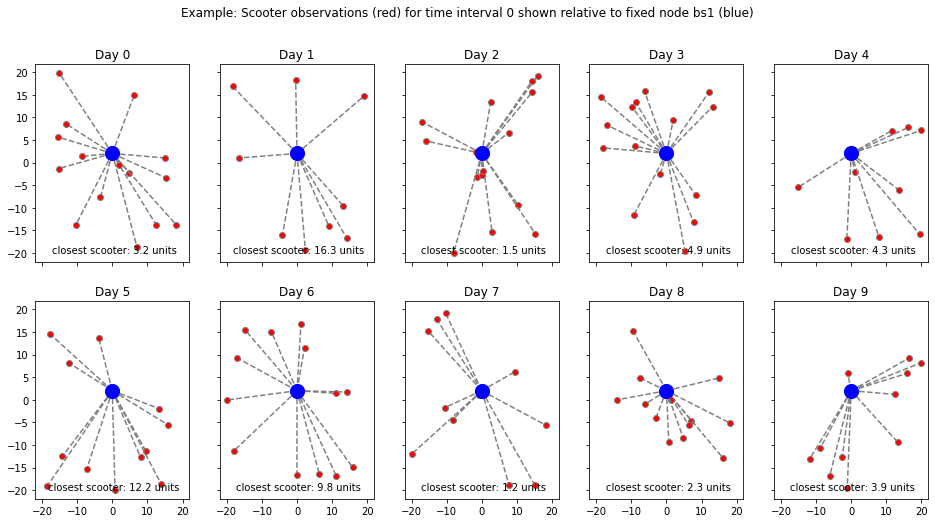

In [299]:
b1, b2 = 1, 0
num_days_of_data = 10
num_obs_LB, num_obs_UB = 6, 16
sc_costs = gen_data(G_u, num_days_of_data, num_intervals, 
                    num_obs_LB, num_obs_UB, 0, 20, 0, 15, nid_map_fixed, b1, b2, speed_params['w'])
#tnc_costs = gen_data(G_u, 10, 6, 6, 15, 0, 20, 0, 15, nid_map_fixed, 1, 1, speed_params['w'])

# Build Transfer Edges

In [300]:
# parameters
modes = ['bs', 'ps', 't', 'k', 'pb', 'sc'] # all modes
pmx = [('ps','ps'),('bs','ps'),('ps','bs'),('ps','t'),('t','ps'),('t','bs'),('bs','t'), # permitted mode change
       ('k','ps'),('k','t'),('k','bs'),('ps','pb'),('pb','ps'),('ps','sc'),('sc','ps'),('k','sc'),('sc','k'),
       ('bs','sc'), ('sc','bs')]  

In [301]:
# # returns catchment a dict in the form {node_ID: nodes within W walking distance}
# # how to make this more efficient: broadcast distance function in numpy array
# # this will immediately find the distance between all nodes
# # this works and is the same procedure as written in paper, but it is inefficient for large networks
# def walking_catchment_zone(i, n_fixed, W):
#     catchment = {}
#     coord_i = n_fixed[i]['pos']
#     for j in n_fixed:
#         if i != j:
#             coord_j = n_fixed[j]['pos']
#             d_ij = np.sqrt((coord_i[0]-coord_j[0])**2 + (coord_i[1]-coord_j[1])**2)
#             if d_ij <= W:
#                 catchment[j] = d_ij
#     return(catchment)

## Construct transfer edges: 1) connect each fixed node to all other fixed nodes within its walking catchment zone  2) connect each fixed node to the nearest node of each flexible network (does the nearest node also need to be within the wcz?) 

### Helper functions for walking catchment zone and nearest neighbor calculation 

In [302]:
# returns walking catchment node for the node of interest
# inputs: nodeID of node interest, matrix of euclidean distances b/w all nodes, and max walking distance
# output: list of nodeIDs of all nodes within the wcz
def wcz(i, dist_matrix, W):
    catchment = np.where(dist_matrix[i] < W)[0].tolist()
    if i in catchment:
        catchment.remove(i)  # remove self
    return catchment

In [303]:
# inputs: node of interest, matrix of euclidean distances b/w all nodes, travel mode of interest, all nodes in the original graph (id+name)
# output: nodeID of the node in the component network of the travel mode of interest that is nearest to the input node of interest
def nn(i, dist_matrix, travel_mode, node_id_map):
    # subset the node_id_map for the nodes in the component network of the travel mode of interest
    nid_map_travel_mode = [key for key,val in node_id_map.items() if val.startswith(travel_mode)]   # this is a list of IDs
    # subset dist matrix for the nodes in the component network of the travel mode of interest
    dist_subset = dist_matrix[:, nid_map_travel_mode]
    # find the node in the component network of interest that is nearest to the input node of interest
    nn_dist = np.amin(dist_subset[i])
    nn_idx = np.argmin(dist_subset[i])
    # now map back to the original node ID
    original_nn_id = nid_map_travel_mode[nn_idx]
    original_nn_name = node_id_map[original_nn_id]
    return (original_nn_id, original_nn_name, nn_dist)

In [304]:
# now create transfer edges: probably should wrap this in a function
W = 6  # max walking distance
inc_cost = 20
trans_edges = {}
#v_sc_nodes = []

for i in list(nid_map_fixed.keys()):
    attrs = {}
    i_name = nid_map[i]  # map back to node name
    catch = wcz(i, euc_dist, W)  # catchment zone around i (includes both fixed and flex nodes)
    # build transfer edge for each fixed node in the catchment zone 
    for j in catch:
        if j in nid_map_fixed.keys():
            j_name = nid_map[j]  # map back to node name
            if (mode(i_name), mode(j_name)) in pmx:         # if mode switch allowed between i and j
                # build the transfer edge
                edge = (i_name, j_name)
                # find the walking time associated with transfer edge, call it walk_cost
                walk_cost = euc_dist[i,j] / speed_params['w']
                # also add an inconvenience cost; this needs to be more carefully considered. make sufficiently large for now
                base_cost = round(walk_cost + inc_cost, 2)
                etype = 'transfer'
                trans_edges[edge] = {'cost': base_cost, 'type': etype} # store the edge with associated attributes
                # add an edge attribute for num_intervals different costs to match the num_intervals time-dependent traversal edge costs
                # but the transfer edge cost is constant for all times 
                cost_dict = {'cost'+str(a): base_cost for a in range(num_intervals)}
                trans_edges[edge].update(cost_dict)    
    
    # find the nearest neighbor in each flex network
    # but first, remove 'pv' nodes to prevent arbitary transfers to the pv network
    # 'pv' nodes are considered flexible for the sake of OD connectors 
    if 'pv' in flex_pre: 
        flex_pre_tx = flex_pre.copy()
        flex_pre_tx.remove('pv')
        
    for m in flex_pre_tx:  
        if (mode(i_name), m) in pmx:    # if mode switch allowed between i and m
            nnID, nnName, nnDist = nn(i, euc_dist, m, nid_map)  # tuple in the form of (node_id, node_name, dist)
            if nnID in catch:   #and (m != 'sc')):
                k_name = nnName
                edge_in = (i_name, k_name)                
                edge_out = (k_name, i_name)
                walk_cost = nnDist / speed_params['w']
                # also add an inconvenience cost; this needs to be more carefully considered 
                
                if m != 'sc':
                    base_cost = round(walk_cost + inc_cost, 2)
                    etype = 'transfer'  # label the transfer edge
                    trans_edges[edge_in] = {'cost': base_cost, 'type': etype} # store the edge with associated attributes
                    trans_edges[edge_out] = {'cost': base_cost, 'type': etype}  # store the edge with associated attributes
                    # add an edge attribute for 5 different costs to match the 5 time-dependent traversal edge costs
                    # but the transfer edge cost is constant for all times 
                    cost_dict = {'cost'+str(a): base_cost for a in range(num_intervals)}
                    trans_edges[edge_in].update(cost_dict)  
                    trans_edges[edge_out].update(cost_dict)  
                    
                else:  # mode is scooter
                    #base_cost = round(sc_obs[i_name]['cost1'],2) + inc_cost
                    # when transferring TO scooter, assign costs that were created above according to historical data
                    cost_dict = sc_costs[i_name]
                    cost_dict_w_inc =  {key: (val + inc_cost) for key, val in cost_dict.items()}  # add inconvenience cost to the cost of walking to scooter
                    cost_dict_w_inc.update({'type': etype})
                    trans_edges[edge_in] = cost_dict_w_inc
                    # when transferring FROM scooter, use nearest neighbor distance
                    trans_edges[edge_out] = {'cost': round(walk_cost,2) + inc_cost, 'type': etype} 
                    cost_dict = {'cost'+str(a): round(walk_cost,2) + inc_cost for a in range(num_intervals)}
                    trans_edges[edge_out].update(cost_dict)  

                
#             else:  # mode is scooter
#                 # add virtual node v associated with i and give it virtual coordinates
#                 v_sc_nodes.append(('vsc'+str(i), {'pos': (G_u_adj.nodes[nid_map[i]]['pos'][0] + 1.5,
#                                                            G_u_adj.nodes[nid_map[i]]['pos'][1] + 1.5)}))
#                 # create a transfer edge (i,v) and (v,i)
#                 edge_in = (i_name, 'vsc'+str(i))
#                 edge_out = ('vsc'+str(i), i_name)
#                 #cost_dict = {'cost'+str(a): 0 for a in range(num_intervals)}
#                 # add the transfer edge and some placeholder cost 
#                 trans_edges[edge_in] = {'cost': 0, 'type': etype}
#                 trans_edges[edge_out] = {'cost': 0, 'type': etype}
            # now we have to build a transfer from the virtual node, whose coordin
#print(trans_edges)

In [305]:
#[edge for edge in trans_edges.keys()]

In [306]:
# G_u.add_nodes_from(v_sc_nodes)
# G_u_adj.add_nodes_from(v_sc_nodes)
# G_u.nodes

In [307]:
# create supernetwork again (in case testing a different W and need to reset edges in G_u)
# combine all the graphs together into one supernetwork
#G_u = nx.union_all(networks_included)
#G_u_adj = nx.union_all(adj_networks_included) 

In [308]:
# add transfer edges and their attributes
G_u.add_edges_from(list(trans_edges.keys()))  # real graph
nx.set_edge_attributes(G_u, trans_edges) # attributes

G_u_adj.add_edges_from(list(trans_edges.keys()))  # adj graph (for drawing purposes)
nx.set_edge_attributes(G_u_adj, trans_edges)  # attributes 

In [309]:
G_u.edges[('bs2', 'sc2')]
G_u.edges[('bs1', 'sc1')]
G_u.edges[('sc1', 'bs1')]  # overlapping nodes in physical world, should have walk cost = 0 but inconvenience cost = 30

{'cost0': 25.57327871379956,
 'cost1': 26.229385434663044,
 'cost2': 25.141134683169405,
 'cost3': 26.390056957910062,
 'cost4': 27.202434258302432,
 'cost5': 27.173236132552788,
 'cost6': 26.293414304536377,
 'cost7': 25.676442748947245,
 'cost8': 25.32149800962007,
 'cost9': 26.555925304116602,
 'type': 'transfer'}

{'cost0': 25.979113549397397,
 'cost1': 27.20021391143592,
 'cost2': 24.80128908966025,
 'cost3': 26.10960478438039,
 'cost4': 24.643591054590896,
 'cost5': 26.46054440454564,
 'cost6': 25.483777944574147,
 'cost7': 25.9454437401902,
 'cost8': 26.767675317502814,
 'cost9': 24.49382514938574,
 'type': 'transfer'}

{'cost': 20.0,
 'type': 'transfer',
 'cost0': 20.0,
 'cost1': 20.0,
 'cost2': 20.0,
 'cost3': 20.0,
 'cost4': 20.0,
 'cost5': 20.0,
 'cost6': 20.0,
 'cost7': 20.0,
 'cost8': 20.0,
 'cost9': 20.0}

## Draw the graphs including transfer edges

In [310]:
# color map for edges. traversal edges are black, transfer edges are gold
# [surcharge for pickup/ dropoff of TNC/scooter/etc]
edge_cmap = ['black' if edge_type == 'traversal' else 'gold' for edge, edge_type in nx.get_edge_attributes(G_u_adj,'type').items()]
#node_szmap = [400 if n.startswith('v') else  600 for n in G_u_adj.nodes ]

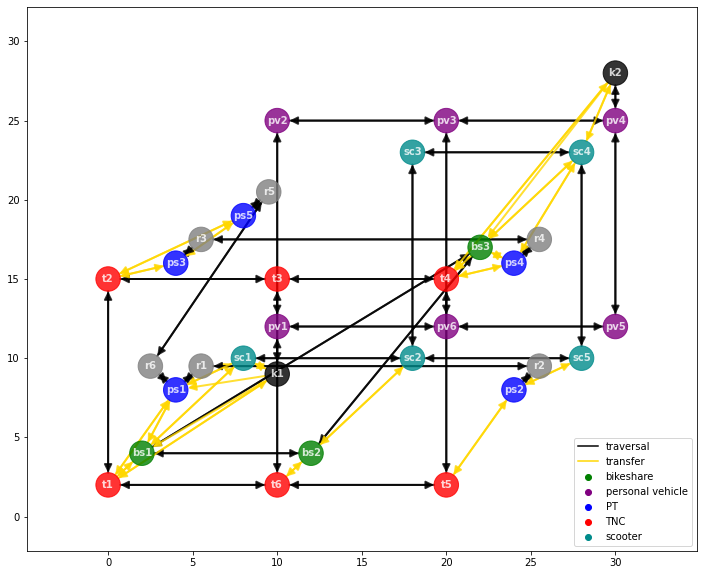

In [311]:
edge_color_type_map = {'black':'traversal', 'gold':'transfer'}
ax = draw_graph(G_u_adj, all_shortmode_cmap, legend_subset, 600, 10, 'white',  edge_cmap, 2)  # without WCZ
add_edge_color_legend(edge_color_type_map, ax, 'lower right')
plt.show()
#draw_graph(G_u_adj, all_shortmode_cmap, legend_subset, 'white',  edge_cmap, 2, 'Y', 'N', fixed_node_list = list(nid_map_fixed.values()), W = W)  # with WCZ

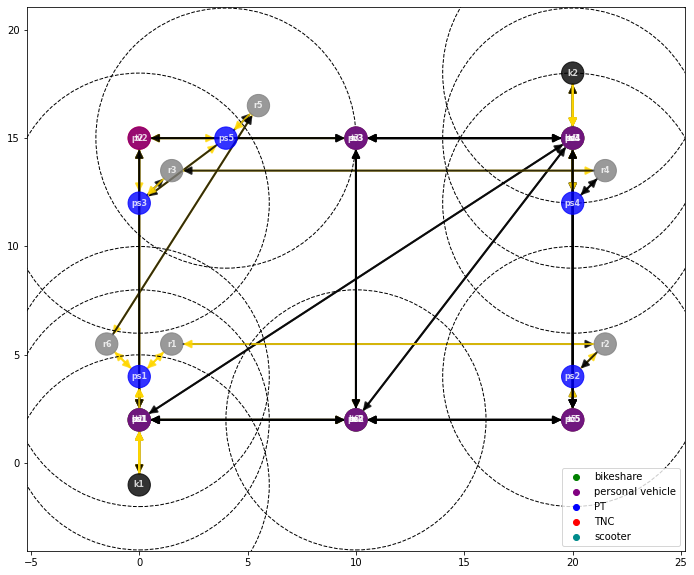

In [312]:
ax = draw_graph(G_u, all_shortmode_cmap, legend_subset, 500, 8, 'white',  edge_cmap, 2)
draw_WCZ(G_u, ax, list(nid_map_fixed.values()), W)

In [313]:
# need to add scooter cost before this can be drawn
#ax = draw_graph(G_u_adj, all_shortmode_cmap, legend_subset, 800, 12, 'white',  edge_cmap, 2)
#labels = {e: round(G_u.edges[e]['cost1'],2) for e in G_u.edges} 
#draw_edge_labels(G_u_adj, ax, labels)

# Assign Boarding and Alighting Costs

In [314]:
# assume boarding and alighting has a static cost of 4 (this can be calibrated with data)
for e in list(G_u.edges):
    if e[0].startswith('ps') and e[1].startswith('r'):
        attr_dict = {'type':'board'}
        cost_dict = {'cost'+str(a): 4 for a in range(num_intervals)}
        attr_dict.update(cost_dict)
        nx.set_edge_attributes(G_u, {e: attr_dict})
        nx.set_edge_attributes(G_u_adj, {e: attr_dict})
    if e[0].startswith('r') and e[1].startswith('ps'):
        attr_dict = {'type':'alight'}
        cost_dict = {'cost'+str(a): 4 for a in range(num_intervals)}
        attr_dict.update(cost_dict)
        nx.set_edge_attributes(G_u, {e: attr_dict})
        nx.set_edge_attributes(G_u_adj, {e: attr_dict})
G_u.edges[('ps3','r3')]

{'cost0': 4,
 'cost1': 4,
 'cost2': 4,
 'cost3': 4,
 'cost4': 4,
 'cost5': 4,
 'cost6': 4,
 'cost7': 4,
 'cost8': 4,
 'cost9': 4,
 'type': 'board'}

# Build OD connectors

In [315]:
# add an origin and a destination with associated coordinates
org, dst = (0,6), (18,12)
od_coords = np.array([list(org),list(dst)])

# add the org and dst nodes to the graph along with their positions 
G_u_od = G_u.copy()  # helpful to do everything on a graph copy 
G_u_od_adj = G_u_adj.copy()
G_u_od.add_nodes_from([('org', {'pos': tuple(od_coords[0])}), 
                     ('dst', {'pos': tuple(od_coords[1])})])
G_u_od_adj.add_nodes_from([('org', {'pos': tuple(od_coords[0])}), 
                         ('dst', {'pos': tuple(od_coords[1])})])

In [316]:
# cell copied from above. can be deleted later. used for now for testing purposes just to make sure nid_map is reset
nid_map = dict([(i, node_id) for i, node_id in enumerate(list(G_u.nodes))])
inv_nid_map = {v: k for k, v in nid_map.items()}

In [317]:
# create new euclidean distance matrix, called euc_dist_od, where euc_dist_od[0,j] is the distance from the org
# to the node with node_id = j and euc_dist_od[1,j] is the distance from the dst to the node with node_id = j

# 2 rows because 1 origin and 1 destination 
nrow, ncol = 2, len(nid_map) + 2  # add 2 to len(nid_map) to account for addition of org node and dst node

euc_dist_od = np.empty([nrow, ncol])  
for i in range(nrow):  # first the org, then the dest
    dist_to_map_nodes = calc_dist(od_coords[i], coord_matrix) # dist from OD to modal graph nodes
    dist_to_od = calc_dist(od_coords[i], od_coords) # dist from O to O and O to D, then D to O and D to D
    euc_dist_od[i] = np.hstack((dist_to_map_nodes, dist_to_od)) # horizontally concatenate 

In [318]:
# now add euc_dist_od to the original euc_dist matrix
# result is euc_dist_all, which contains the euc dist b/w all pairs of nodes in the graph, including org and dst
euc_dist_all = np.vstack((euc_dist, euc_dist_od[:,:len(nid_map)]))
euc_dist_all = np.hstack((euc_dist_all, np.transpose(euc_dist_od)))
euc_dist_all.shape
# add the org and dest to the nid_map and recreate the inverse map
nid_map[max(nid_map.keys())+1] = 'org'
nid_map[max(nid_map.keys())+1] = 'dst'
inv_nid_map = {v: k for k, v in nid_map.items()}

(35, 35)

In [319]:
# get scooter and TNC data
nid_map_od = {nid:name for nid, name in nid_map.items() if nid in [inv_nid_map['org']] + [inv_nid_map['dst']]}
nid_map_od
#sc_costs = gen_data(G_u, 10, 6, 6, 15, 0, 20, 0, 15, nid_map_fixed, 1, 1, speed_params['w'])

{33: 'org', 34: 'dst'}

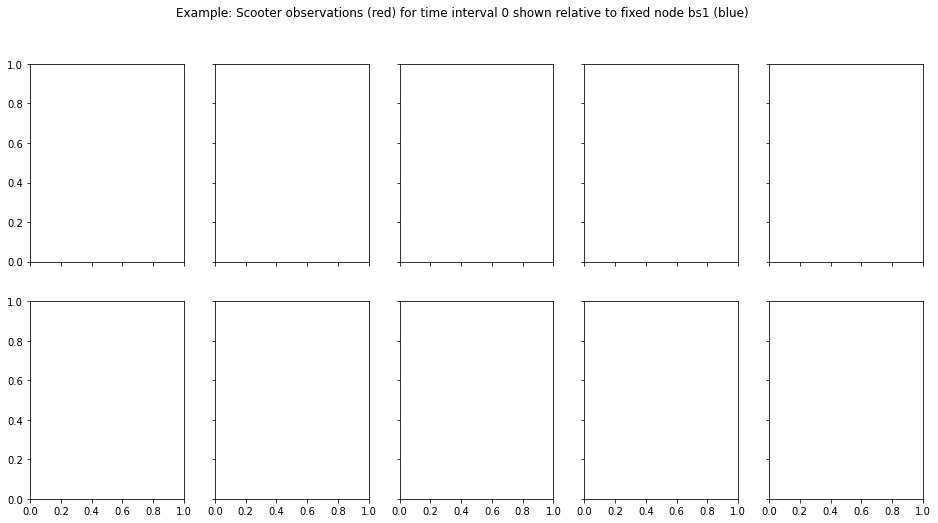

In [320]:
# cost of transferring to scooter from ORG and to DST from scooter 
sc_costs_od = gen_data(G_u_od, 10, 6, 6, 15, 0, 20, 0, 15, nid_map_od, 1, 1, speed_params['w'])

In [321]:
# this function builds OD connectors on the fly
# input: graphs, coordinates of the org and dst, the nodeID map, list of fixed nodes, list of flex modes, 
# euclidean dist between all nodes in the graph, max walk distance W, and walk speed parameter 
# output: graphs with OD connector edges added, along with their associated cost 

# note that there are some exceptions: 
# 1) org connects to flex PV;  2) org does not connect to fixed parking;  3) dst does not connect to flex PV
# 4) dst connects to fixed parking
def od_cnx(G, G_adj, od_coord_matrix, node_id_map, fixed_node_list, fixed_mode_list, 
           flex_mode_list, euc_dist_matrix, W, walk_speed, scooter_costs):
    inv_node_id_map = {v: k for k, v in node_id_map.items()}
    
    for i_name in ['org', 'dst']:
        catch = wcz(inv_node_id_map[i_name], euc_dist_matrix, W)  # find WCZ
        #print(i_name)
        #print('-----')
        # build od connector edge for each fixed node in the catchment zone 
        for j in catch:
            if j in fixed_node_list:
                j_name = node_id_map[j]  # map back to node name
                #print(j_name, mode(j_name))
                if (i_name == 'org' and mode(j_name) == 'k'):   # exception 2
                    continue
                if i_name == 'org':
                    edge = (i_name, j_name)  # build org connector
                if i_name == 'dst':
                    edge = (j_name, i_name)  # build dst connector
                
                walk_cost = round(euc_dist_matrix[inv_node_id_map[i_name], j]/walk_speed, 2)  # walking traversal time of edge
                cost_dict = {'cost'+str(a): walk_cost for a in range(num_intervals)}
                attr = {'type':'cnx', 'cost': walk_cost}
                attr.update(cost_dict)
                add_and_set_edge_attributes([G, G_adj], edge, attr)
 
        # some fixed modes do not have a node within the wcz. for these modes, we will instead connect the 
        # org or dst to the nearest neighbor node of for these specific fixed modes. consider this like 
        # relaxing the wcz constraint
        catch_node_names = [node_id_map[c] for c in catch]
        catch_fixed_modes = [re.sub(r'[^a-zA-Z]', '', cname) for cname in catch_node_names]
        
        # which fixed mode does not have a node in the wcz?
        rem_fixed_modes = set(fixed_mode_list) - set(catch_fixed_modes)
        for rm in rem_fixed_modes:
            #print('rm:', rm)
            if (i_name == 'org' and rm == 'k'):   # exception 2
                continue
            # nn calc
            nnID, nnName, nnDist = nn(inv_nid_map[i_name], euc_dist_matrix, rm, node_id_map) 
            r_name = nnName
            #print(r_name)
            cnx_edge_length = nnDist
            walk_cost = round(cnx_edge_length/walk_speed, 2)
            cost_dict = {'cost'+str(a): walk_cost for a in range(num_intervals)}

            if i_name == 'org':
                edge = (i_name, r_name)  # build org connector
            if i_name == 'dst':
                edge = (r_name, i_name)  # build dst connector

            attr = {'type':'cnx', 'cost': walk_cost}
            attr.update(cost_dict)
            add_and_set_edge_attributes([G, G_adj], edge, attr)


        # build od connector edge for the nearest flexible node (relax constraints that needs to be in wcz)
        # also includes an org connector from org to nearest PV node, but does NOT include a dst connector from dst to nearest PV node
        # PV = personal vehicle 
        for m in flex_mode_list:
            if i_name == 'dst' and m == 'pv':  # exception 3
                continue
            nnID, nnName, nnDist = nn(inv_nid_map[i_name], euc_dist_matrix, m, node_id_map) 
            k_name = nnName
            #print(k_name)
            #if nnID in catch:   *we have decided to relax this constraint*
            
            # do this separately for scooters/TNCs and other flex modes. for now, TNCs treated like other fixed modes
            if (i_name == 'org' and m == 'sc'):
                edge = (i_name, k_name)
                #print(edge)
                cost_dict = scooter_costs[i_name]
                attr = {'type':'cnx', 'cost': walk_cost}
                attr.update(cost_dict)
                add_and_set_edge_attributes([G, G_adj], edge, attr)   
                #print('*****')
            else:   
                cnx_edge_length = nnDist
                walk_cost = round(cnx_edge_length/walk_speed, 2)
                cost_dict = {'cost'+str(a): walk_cost for a in range(num_intervals)}

                if i_name == 'org':
                    edge = (i_name, k_name)  # build org connector
                if i_name == 'dst':
                    edge = (k_name, i_name)  # build dst connector
                #print(edge)
                attr = {'type':'cnx', 'cost': walk_cost}
                attr.update(cost_dict)
                add_and_set_edge_attributes([G, G_adj], edge, attr)    

In [322]:
# call function to add od connectors. note that od connectors are added on the fly, which means that the connectors
# are only added for one OD pair at a time. this ensures that the shortest path between one OD pair does not include
# OD connectors from another OD pair
od_cnx(G_u_od, G_u_od_adj, od_coords, nid_map, list(nid_map_fixed.keys()), fix_pre,
       flex_pre, euc_dist_all, W, speed_params['w'], sc_costs_od)

In [323]:
nodes_included = [n for m, nodes in all_modes_nodes.items() for n in nodes if m in modes_included] + ['org','dst']
legend_subset = node_color_legend(nodes_included, all_mode_namemap, all_shortmode_cmap)
edge_cmap = ['black' if edge_type == 'traversal' else('gold' if edge_type == 'transfer' \
                 else ('magenta' if edge_type == 'cnx' else 'dimgrey')) \
                 for edge, edge_type in nx.get_edge_attributes(G_u_od_adj,'type').items()]
edge_color_type_map = {'black':'traversal', 'gold':'transfer', 'magenta':'od_cnx', 'dimgrey': 'board/alight'}

Text(0.5, 1.0, 'Full graph, including traversal edges, transfer edges, and OD connector edges')

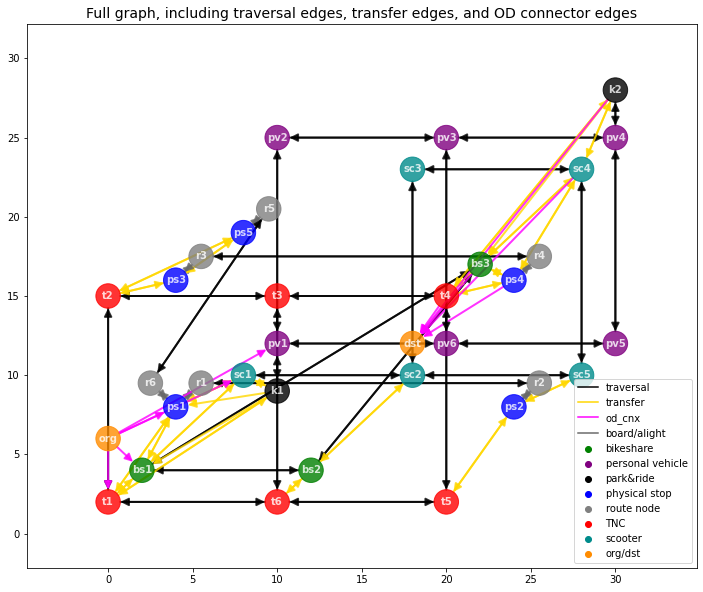

In [324]:
ax = draw_graph(G_u_od_adj, all_shortmode_cmap, legend_subset, 600, 10, 'white',  edge_cmap, 2)  
ax.set_title('Full graph, including traversal edges, transfer edges, and OD connector edges' , fontsize = 14)
add_edge_color_legend(edge_color_type_map, ax, 'lower right')
plt.show()

In [325]:
# testing for the OD connectors 
i = 4
od_cnx_edge = [e for e in G_u_od_adj.edges if (e[0]=='org' or e[1]=='dst')]
for e in od_cnx_edge:
    print(e, G_u_od.edges[e[0],e[1]]['cost'+str(i)])

('t4', 'dst') 3.61
('bs3', 'dst') 3.61
('ps4', 'dst') 2.0
('sc4', 'dst') 3.61
('k2', 'dst') 6.32
('org', 'bs1') 4.0
('org', 'ps1') 2.0
('org', 't1') 4.0
('org', 'sc1') 22.41118421149978
('org', 'pv1') 4.0


# Shortest Path

## Single Shortest Path Example

In [326]:
def sp_string(sp_edges):
    s = ''
    for i, e in enumerate(sp_edges):
        s = s + ' ' + e[0]
        if i == len(sp_edges) - 1:
            s = s + ' ' + 'dst'
    return(s)

In [327]:
sp = nx.dijkstra_path(G_u_od, 'org', 'dst', 'cost1')
sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)] 

Text(0.5, 1.0, 'Shortest Path between Org and Dst \n org ps1 r1 r2 ps2 t5 t4 dst')

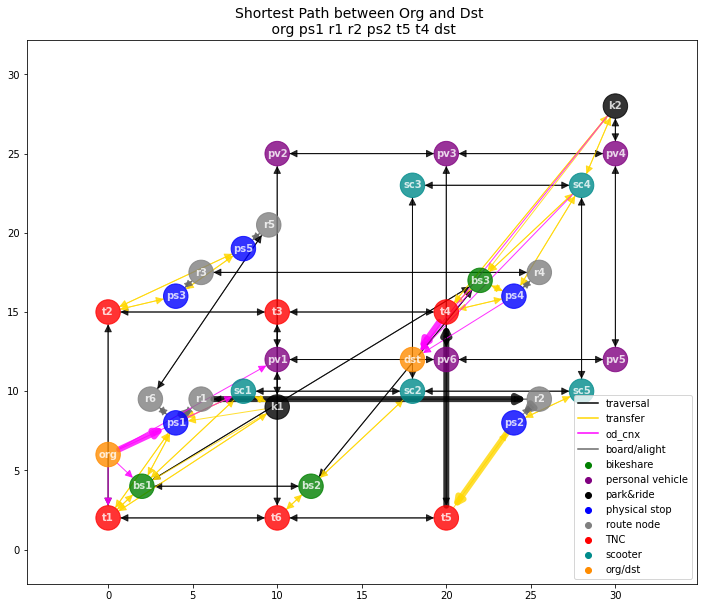

In [328]:
# draw the shortest path
sp_edgewidth = [6 if e in sp_edges else 1 for e in G_u_od_adj.edges]
ax = draw_graph(G_u_od_adj, all_shortmode_cmap, legend_subset, 600, 10, 'white', edge_cmap, sp_edgewidth)
ax.set_title('Shortest Path between Org and Dst \n' + sp_string(sp_edges), fontsize = 14)
add_edge_color_legend(edge_color_type_map, ax, 'lower right')

## Find the total cost of the shortest path

In [329]:
total_cost = sp_total_cost(G_u_od, sp_edges, 'cost1')
total_cost

98.11428325024623

## Time Dependent Shortest Path

In [330]:
num_intervals

10

84.47001262074208

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost0\n org t1 t6 t5 t4 dst')

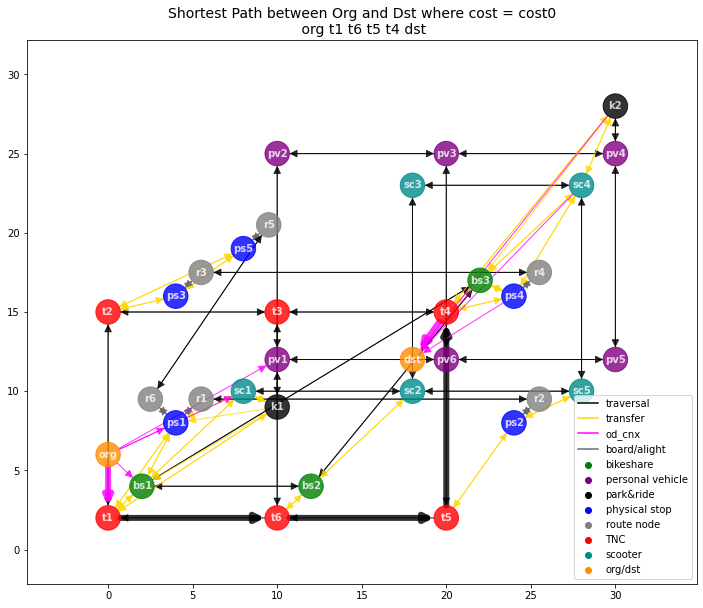

98.11428325024623

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost1\n org ps1 r1 r2 ps2 t5 t4 dst')

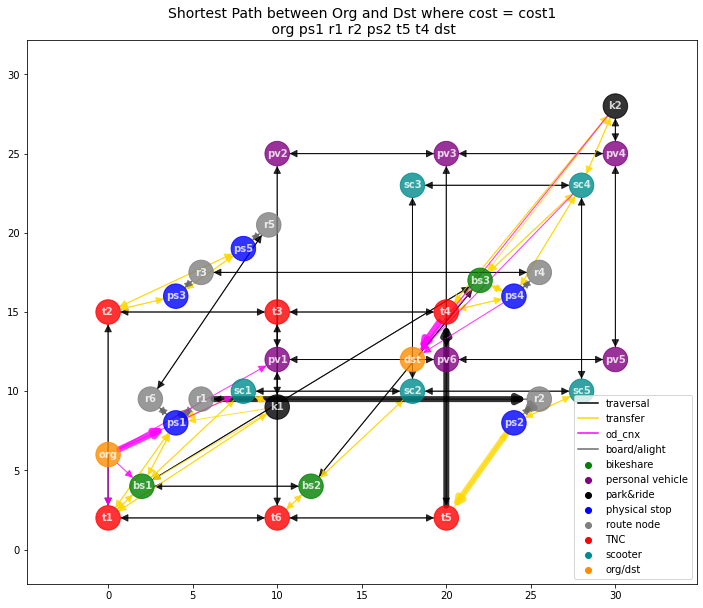

110.23959274728607

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost2\n org bs1 bs3 dst')

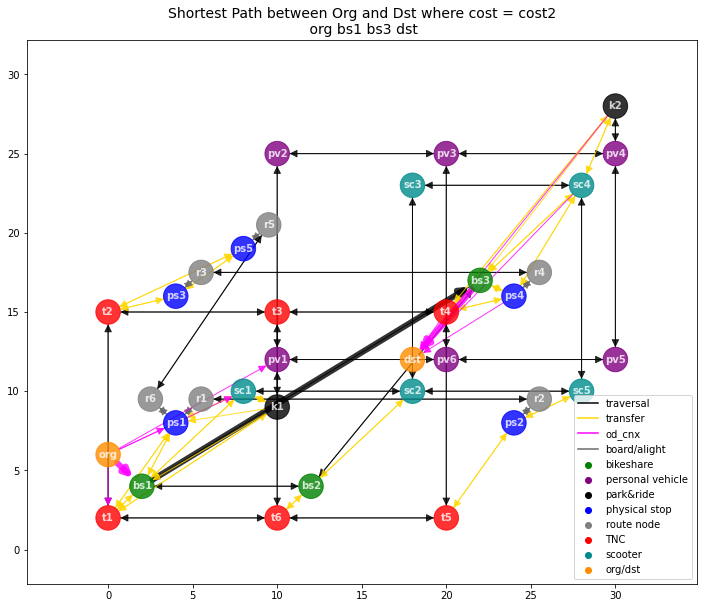

97.87317389267082

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost3\n org t1 t2 ps3 r3 r4 ps4 dst')

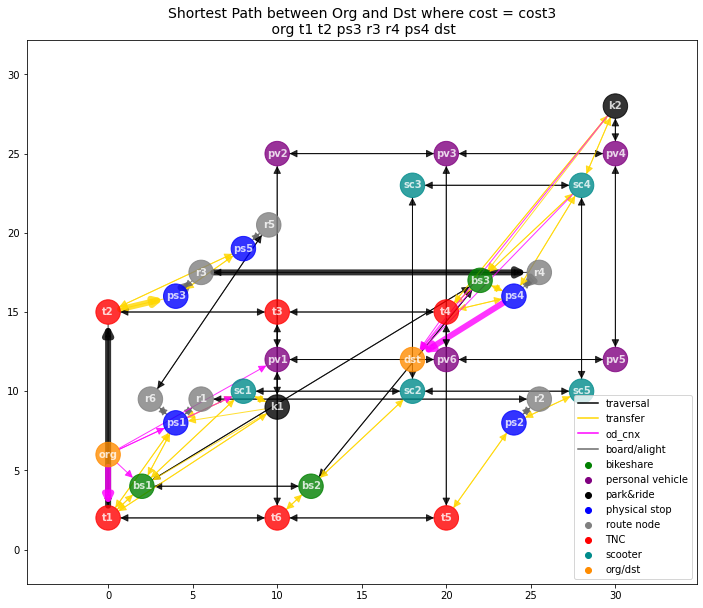

101.89502251560504

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost4\n org ps1 r1 r2 ps2 sc5 sc4 dst')

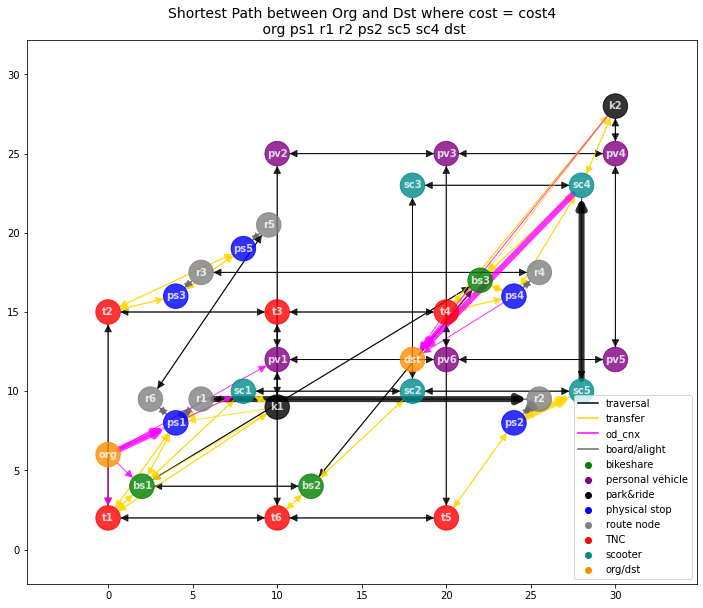

110.23959274728607

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost5\n org bs1 bs3 dst')

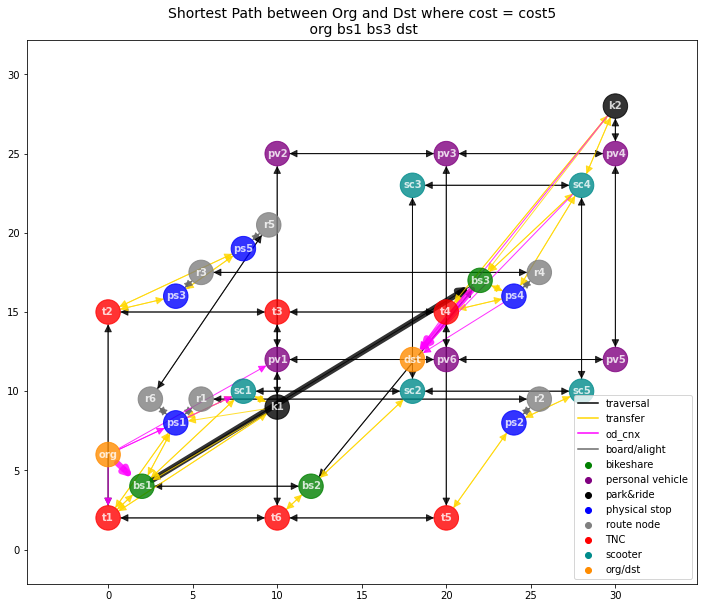

110.23959274728607

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost6\n org bs1 bs3 dst')

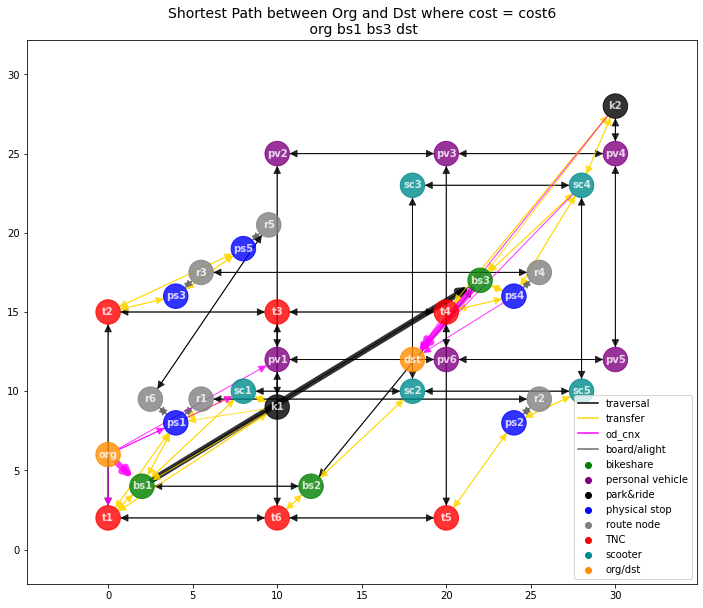

86.57702082026557

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost7\n org t1 t2 ps3 r3 r4 ps4 dst')

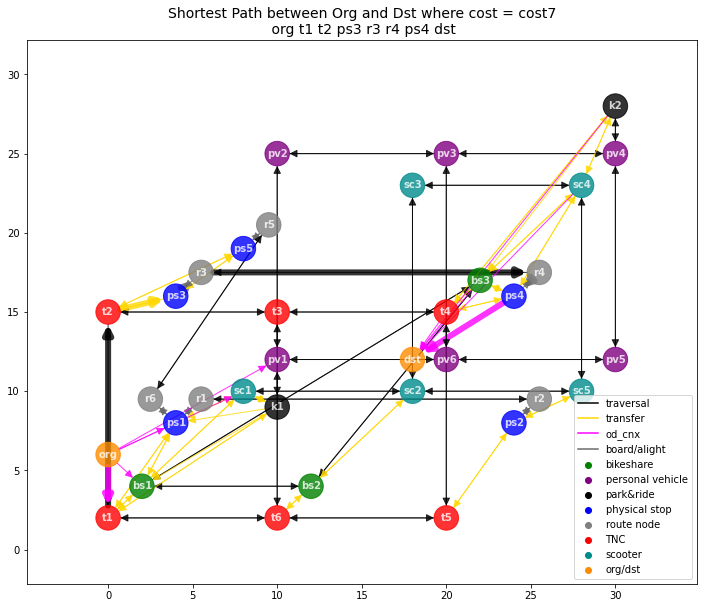

95.98775377231338

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost8\n org t1 t2 ps3 r3 r4 ps4 dst')

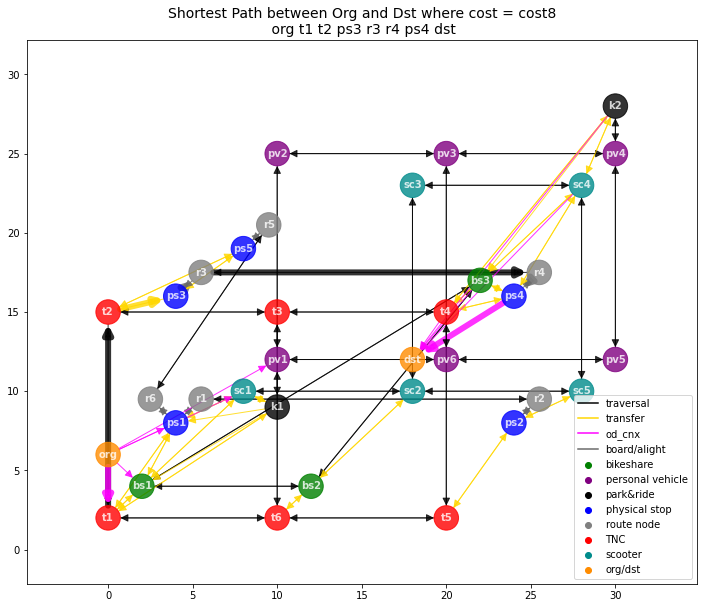

110.23959274728607

Text(0.5, 1.0, 'Shortest Path between Org and Dst where cost = cost9\n org bs1 bs3 dst')

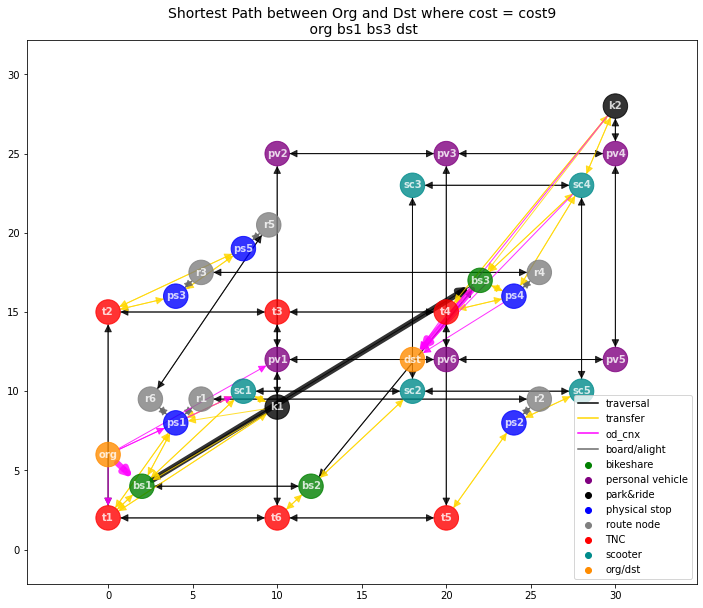

In [331]:
tdsp = {}
for i in range(num_intervals):
    weight = 'cost' + str(i)  # specify which weight parameter to use
    sp = nx.dijkstra_path(G_u_od, 'org', 'dst', weight)  # find the sp
    sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)]  # find the sp edges
    tdsp[i] = sp_edges  # store the sp edges for the given time interval
    sp_total_cost(G_u_od, sp_edges, 'cost'+str(i))  # find the cost
    # draw the shortest path
    sp_edgewidth = [6 if e in sp_edges else 1 for e in G_u_od_adj.edges]
    ax = draw_graph(G_u_od_adj, all_shortmode_cmap, legend_subset, 600, 10, 'white', edge_cmap, sp_edgewidth)
    ax.set_title('Shortest Path between Org and Dst where cost = ' 'cost'+str(i) + '\n' + sp_string(sp_edges),
                 fontsize = 14)
    add_edge_color_legend(edge_color_type_map, ax, 'lower right')
    plt.show()

# Notes and Questions 

## To do
1. COMPLETE: create random, dynamic (time-dependent) edge weights to test out mode change (must adhere to FIFO). are the resulting mode sequences logical? <br>
1. COMPLETE: make single directional, including OD connectors <br>
1. **constraint on number of mode changes? build in some kind of inconvenience cost into transfer edges. i currently have some static inconvience cost (20 "cost units") but need to think of a better idea. can review some literature about this** <br>
1. COMPLETE: add OD connectors; i think they can be added on the fly. alternatively, they can all be added at once. this might be a better option <br>
1. COMPLETE: add scooter network, make some fake data to test the edge cost calculation <br>
1. **scooter-like edge cost calculation for TNC in order to incorporate waiting cost.** <br>
1. COMPLETE: incorporate historical scooter edge cost for OD connector <br>
1. COMPLETE: PV network: separate parking nodes <br>
1. COMLETE: PT network: add one more route, have two or more routes share a physical stop, add boarding/alighting nodes <br>
1. COMPLETE: align all unimodal networks to reflect physical reality <br>
1. **Think about how to deal with costs of public transit. right now, I have a static boarding and alighting cost (both boarding and alighting edges are associated with 4 "cost units"), and then I enforce FIFO constraint when assigning the random route edge costs (traversal edges). I have not yet incorporated transit frequency into this model. Need to think more critically about proper way to do this. Idea: create a mock transit schedule and embed waiting cost into the cost of the alighting edge** <br>
1. **Resoultion of time dependent SP? I have thus far considered 10 different time intervals, each of length = 30 seconds. Traversal costs are generated randomly, transfer edge costs are generated as the cost of walking from a node in one network to a node in another netowrk. Cost of walking is defined as the walking time, i.e. walk_dist/walk_speed** <br>
 

## Questions:
1) when creating org/dst connectors, does the nearest flexible node need to be in the walking catchment zone (wcz)? <br>
2) similarly, when creating transfer edges, does the nearest flexible node need to be in the wcz? <br> 
3) when creating od connectors, should there be an edge that connects each org/dst to every unimodal network node, regardless of whether the edge extends beyond the wcz? <br>
5/25 meeting: relax the wcz constraint for OD connectors. Keep them for transfer edges (for now)

1) What kind of data will we have available to determine avg and 95th percentile waiting time for a TNC vehicle? This will inform how I generate some fake data to test out the TNC waiting cost calculation
2) What kind of public transit data will we be using? i.e. what are the outputs of Daryn's work? This will address the last point above 